In [ ]:
import random
import pandas as pd

In [ ]:
VALUES = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}

In [ ]:
class Shoe:
    def __init__(self, num_decks=6):
        self.num_decks = num_decks
        self.cards = []
        self.reset()

    def reset(self):
        # Création de X paquets de 52 cartes
        deck = list(VALUES.keys()) * 4
        self.cards = deck * self.num_decks
        random.shuffle(self.cards)

    def deal(self):
        if not self.cards:
            self.reset() # Remélanger si vide (ou gérer le "cut card")
        return self.cards.pop()

In [ ]:
def calculate_hand(hand):
    val = sum(VALUES[card] for card in hand)
    # Gestion des As (11 ou 1)
    num_aces = hand.count('A')
    while val > 21 and num_aces:
        val -= 10
        num_aces -= 1
    return val

In [ ]:
def play_dealer_hand(dealer_hand, shoe):
    # Règle classique : Le croupier tire jusqu'à 17
    while calculate_hand(dealer_hand) < 17:
        dealer_hand.append(shoe.deal())
    return calculate_hand(dealer_hand)

In [ ]:
def simulate_game(strategy_func, num_iterations=10000):
    shoe = Shoe(num_decks=6)
    balance = 0
    wins, losses, draws = 0, 0, 0

    for _ in range(num_iterations):
        # 1. Distribution initiale
        player_hand = [shoe.deal(), shoe.deal()]
        dealer_hand = [shoe.deal(), shoe.deal()]
        dealer_up = dealer_hand[0]

        # 2. Tour du Joueur
        while True:
            action = strategy_func(player_hand, dealer_up)
            if action == "STAND":
                break
            elif action == "HIT":
                player_hand.append(shoe.deal())
                if calculate_hand(player_hand) > 21:
                    break # Busted

        # 3. Résolution
        p_val = calculate_hand(player_hand)

        if p_val > 21:
            balance -= 1 # Joueur perd
            losses += 1
        else:
            d_val = play_dealer_hand(dealer_hand, shoe)
            if d_val > 21 or p_val > d_val:
                balance += 1 # Joueur gagne
                wins += 1
            elif p_val < d_val:
                balance -= 1 # Joueur perd
                losses += 1
            else:
                draws += 1 # Égalité

    return balance, wins, losses, draws

# Never Bust

In [ ]:
def strategy_never_bust(player_hand, dealer_up_card, limit):
    if calculate_hand(player_hand) < limit:
        return "HIT"
    else:
        return "STAND"

In [ ]:
limits_to_test = range(0, 22) # Testing limits from 0 to 21 (inclusive)
win_rates = []

for limit in limits_to_test:
    current_strategy_func = lambda ph, duc: strategy_never_bust(ph, duc, limit)

    balance, wins, losses, draws = simulate_game(current_strategy_func, num_iterations=100000)

    total_games = wins + losses + draws
    if total_games > 0:
        win_rate = wins / total_games
    else:
        win_rate = 0

    win_rates.append(win_rate)

print("Limits tested:", list(limits_to_test))
print("Corresponding win rates:", [f"{wr:.2%}" for wr in win_rates])

Limits tested: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Corresponding win rates: ['38.19%', '38.14%', '37.95%', '38.08%', '38.04%', '37.84%', '37.62%', '38.07%', '37.98%', '38.21%', '39.02%', '39.85%', '41.28%', '41.63%', '41.86%', '41.32%', '41.29%', '40.73%', '39.75%', '36.09%', '29.41%', '15.79%']


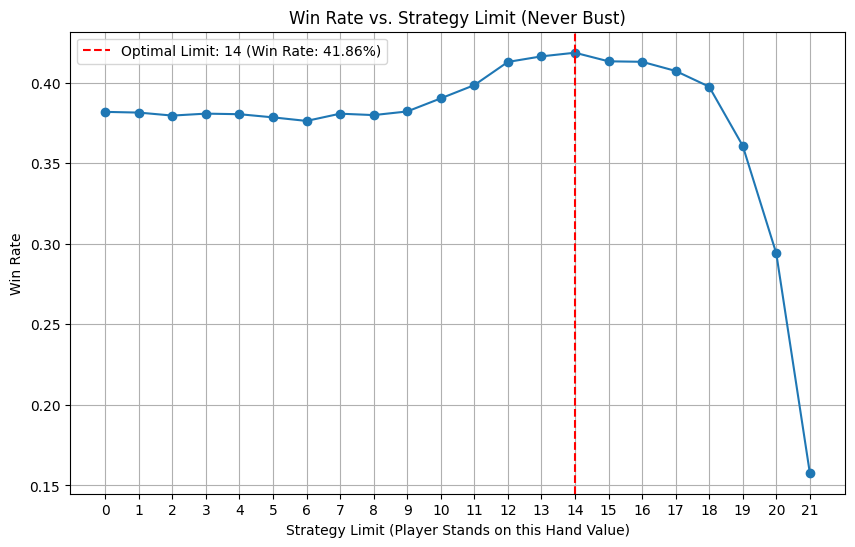

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(list(limits_to_test), win_rates, marker='o')
plt.title('Win Rate vs. Strategy Limit (Never Bust)')
plt.xlabel('Strategy Limit (Player Stands on this Hand Value)')
plt.ylabel('Win Rate')
plt.grid(True)
plt.xticks(list(limits_to_test)) # Ensure all limits are shown on x-axis
plt.axvline(x=limits_to_test[win_rates.index(max(win_rates))], color='r', linestyle='--', label=f'Optimal Limit: {limits_to_test[win_rates.index(max(win_rates))]} (Win Rate: {max(win_rates):.2%})')
plt.legend()
plt.show()


# Simplified Strategy

In [ ]:
def strategy_parametrized(player_hand, dealer_up_card, hit_threshold, stand_threshold):
    player_val = calculate_hand(player_hand)
    dealer_val = VALUES[dealer_up_card]

    if player_val <= hit_threshold:
        return "HIT"
    elif player_val >= stand_threshold:
        return "STAND"
    else:
        # Between thresholds, use dealer's up-card
        if dealer_val >= 7:
            return "HIT"
        else:
            return "STAND"

In [ ]:
hit_thresholds = range(1, 21)
stand_thresholds = range(2, 22)

win_rates_grid = []

optimal_win_rate = 0
optimal_hit_threshold = 0
optimal_stand_threshold = 0

for h_thresh in hit_thresholds:
    row_win_rates = []
    for s_thresh in stand_thresholds:
        if h_thresh < s_thresh:
            current_strategy_func = lambda ph, duc: strategy_parametrized(ph, duc, h_thresh, s_thresh)

            balance, wins, losses, draws = simulate_game(current_strategy_func, num_iterations=100000)

            total_games = wins + losses + draws
            if total_games > 0:
                current_win_rate = wins / total_games
            else:
                current_win_rate = 0

            row_win_rates.append(current_win_rate)

            if current_win_rate > optimal_win_rate:
                optimal_win_rate = current_win_rate
                optimal_hit_threshold = h_thresh
                optimal_stand_threshold = s_thresh
        else:
            # Invalid combination, append 0 or None to maintain grid structure for visualization later if needed
            row_win_rates.append(0) # Or use float('nan')
    win_rates_grid.append(row_win_rates)

print(f"Optimal Hit Threshold: {optimal_hit_threshold}")
print(f"Optimal Stand Threshold: {optimal_stand_threshold}")
print(f"Optimal Win Rate: {optimal_win_rate:.2%}")

Optimal Hit Threshold: 12
Optimal Stand Threshold: 17
Optimal Win Rate: 42.67%


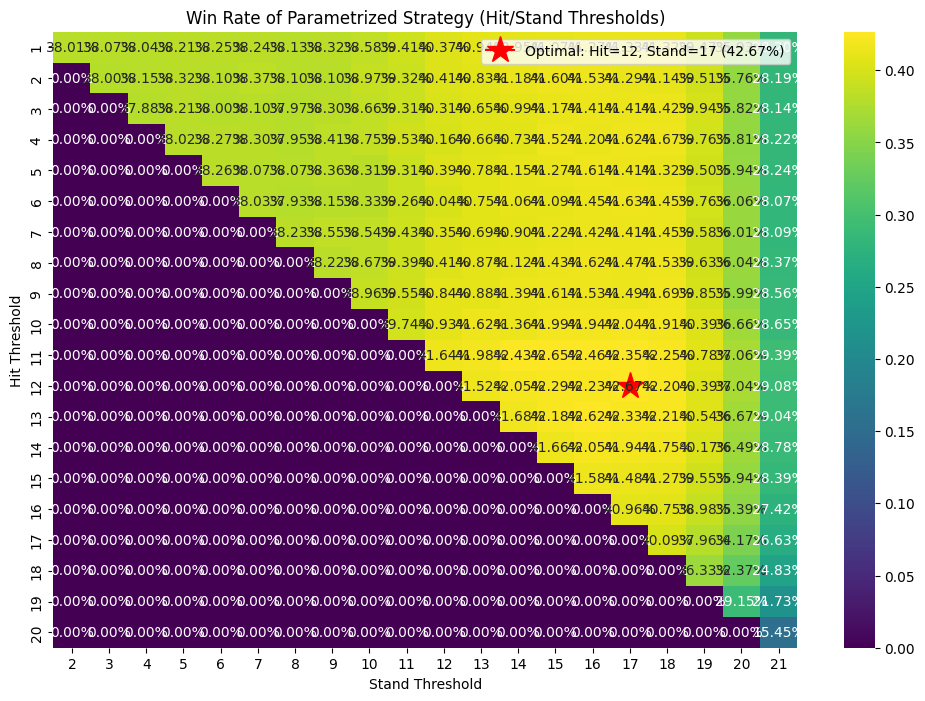

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 8))
sns.heatmap(np.array(win_rates_grid), annot=True, fmt=".2%", cmap="viridis",
            xticklabels=list(stand_thresholds), yticklabels=list(hit_thresholds))
plt.title('Win Rate of Parametrized Strategy (Hit/Stand Thresholds)')
plt.xlabel('Stand Threshold')
plt.ylabel('Hit Threshold')

# Highlight optimal parameters
# Adjusting indices for heatmap where 0,0 is top-left
# Optimal hit_threshold and stand_threshold are values, need to find their indices
hit_idx = list(hit_thresholds).index(optimal_hit_threshold)
stand_idx = list(stand_thresholds).index(optimal_stand_threshold)

plt.plot(stand_idx + 0.5, hit_idx + 0.5, marker='*', markersize=20, color='red', label=f'Optimal: Hit={optimal_hit_threshold}, Stand={optimal_stand_threshold} ({optimal_win_rate:.2%})')
plt.legend()
plt.show()

# Hi-Low Strategy

In [ ]:
HI_LO_VALUES = {
    '2': 1, '3': 1, '4': 1, '5': 1, '6': 1,
    '7': 0, '8': 0, '9': 0,
    '10': -1, 'J': -1, 'Q': -1, 'K': -1, 'A': -1
}

In [ ]:
class SmartShoe:
    def __init__(self, num_decks=6, penetration=0.75):
        """
        penetration: Pourcentage du sabot distribué avant mélange (ex: 0.75 = on joue 75% des cartes)
        """
        self.num_decks = num_decks
        self.penetration = penetration
        self.cards = []
        self.running_count = 0
        self.reset()

    def reset(self):
        deck = list(HI_LO_VALUES.keys()) * 4
        self.cards = deck * self.num_decks
        random.shuffle(self.cards)
        self.running_count = 0
        # Point de coupe (Cut card)
        self.reshuffle_point = len(self.cards) * (1 - self.penetration)

    def deal(self):
        # Si on atteint la "cut card", on remélange
        if len(self.cards) < self.reshuffle_point:
            self.reset()

        card = self.cards.pop()

        # Mise à jour du Running Count
        # Note: Dans la réalité, on ne compte que les cartes VISIBLES.
        self.running_count += HI_LO_VALUES[card]

        return card

    def get_true_count(self):
        # Formule : Running Count / Paquets restants (arrondi à 0.5 près ou entier)
        decks_remaining = len(self.cards) / 52
        if decks_remaining < 1: decks_remaining = 1 # Éviter division par zéro
        return round(self.running_count / decks_remaining)

In [ ]:
def get_bet_size(true_count, unit_bet=10):
    """
    Stratégie de mise agressive :
    - Si le compte est <= 1, on mise le minimum (1 unité).
    - Si le compte monte, on augmente exponentiellement jusqu'à un max.
    """
    if true_count <= 1:
        return unit_bet
    elif true_count == 2:
        return unit_bet * 2
    elif true_count == 3:
        return unit_bet * 4
    elif true_count >= 4:
        return unit_bet * 8 # Max bet
    return unit_bet

In [ ]:
def simulate_counting(n_hands=20000):
    shoe = SmartShoe(num_decks=6, penetration=0.75) # Pénétration standard
    bankroll = 10000 # Bankroll de départ
    history = [] # Pour le graphique

    for i in range(n_hands):
        # 1. Le joueur regarde le True Count AVANT de miser
        tc = shoe.get_true_count()
        bet = get_bet_size(tc, unit_bet=10)

        # 2. Distribution
        p_hand = [shoe.deal(), shoe.deal()]
        d_hand = [shoe.deal(), shoe.deal()]

        # 3. Jeu du joueur (Basic Strategy)
        while True:
            action = strategy_never_bust(p_hand, d_hand[0], limit=14)
            if action == "STAND": break
            p_hand.append(shoe.deal())
            if calculate_hand(p_hand) > 21: break

        # 4. Résolution
        p_val = calculate_hand(p_hand)
        d_val = 0

        result = 0
        if p_val > 21:
            result = -bet
        else:
            d_val = play_dealer_hand(d_hand, shoe)
            if d_val > 21 or p_val > d_val:
                # Blackjack paie 3:2 (simplifié ici à 1:1 ou 1.5 pour BJ)
                # Pour le code simple on fait 1:1
                result = bet
            elif p_val < d_val:
                result = -bet
            else:
                result = 0 # Push

        bankroll += result
        history.append(bankroll)

    return history

In [ ]:
history = simulate_counting(n_hands=3000)

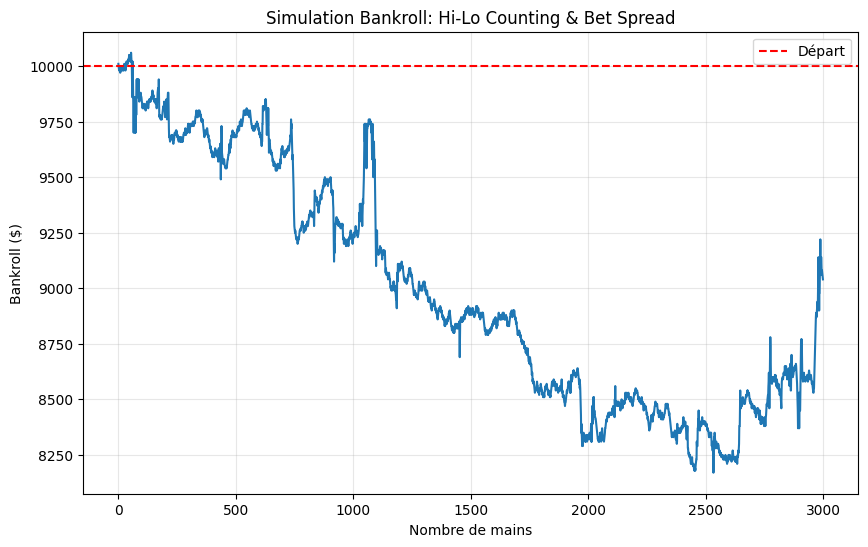

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history)
plt.title("Simulation Bankroll: Hi-Lo Counting & Bet Spread")
plt.xlabel("Nombre de mains")
plt.ylabel("Bankroll ($)")
plt.grid(True, alpha=0.3)
# Ajouter une ligne rouge pour le point de départ
plt.axhline(y=10000, color='r', linestyle='--', label="Départ")
plt.legend()
plt.show()

# Hard table

In [ ]:
class BlackjackAdvisor:
    def __init__(self):
        # Légende : H=Hit, S=Stand, D=Double (sinon Hit), Ds=Double (sinon Stand), P=Split
        self.create_strategy_tables()

    def create_strategy_tables(self):
        # 1. TABLE DES PAIRES (Priorité 1)
        # Ligne = Carte de la paire, Colonne = Carte du Dealer (2-9, T, A)
        self.pairs = {
            'A': ['P'] * 10,                 # Toujours spliter les As
            '10':['S'] * 10,                 # Jamais spliter les 10 (20 est trop fort)
            '9': ['P', 'P', 'P', 'P', 'P', 'S', 'P', 'P', 'S', 'S'], # Stand sur 7, 10, A
            '8': ['P'] * 10,                 # Toujours spliter les 8
            '7': ['P', 'P', 'P', 'P', 'P', 'P', 'H', 'H', 'H', 'H'],
            '6': ['P', 'P', 'P', 'P', 'P', 'H', 'H', 'H', 'H', 'H'],
            '5': ['D'] * 8 + ['H', 'H'],     # Double sur 2-9, sinon Hit (traité comme un 10 dur)
            '4': ['H', 'H', 'H', 'P', 'P', 'H', 'H', 'H', 'H', 'H'],
            '3': ['P', 'P', 'P', 'P', 'P', 'P', 'H', 'H', 'H', 'H'],
            '2': ['P', 'P', 'P', 'P', 'P', 'P', 'H', 'H', 'H', 'H']
        }

        # 2. TABLE DES MAINS SOUPLES (Soft Totals - Avec un As)
        # Ligne = L'autre carte (ex: pour A-6, on regarde '6')
        self.soft = {
            '9': ['S'] * 10,                # A-9 (20) -> Stand
            '8': ['S', 'S', 'S', 'S', 'Ds', 'S', 'S', 'S', 'S', 'S'], # A-8 (19) -> Souvent Stand
            '7': ['S', 'Ds', 'Ds', 'Ds', 'Ds', 'S', 'S', 'H', 'H', 'H'], # A-7 (18)
            '6': ['H', 'D', 'D', 'D', 'D', 'H', 'H', 'H', 'H', 'H'],     # A-6 (17)
            '5': ['H', 'H', 'D', 'D', 'D', 'H', 'H', 'H', 'H', 'H'],
            '4': ['H', 'H', 'D', 'D', 'D', 'H', 'H', 'H', 'H', 'H'],
            '3': ['H', 'H', 'H', 'D', 'D', 'H', 'H', 'H', 'H', 'H'],
            '2': ['H', 'H', 'H', 'D', 'D', 'H', 'H', 'H', 'H', 'H']
        }

        # 3. TABLE DES MAINS DURES (Hard Totals)
        # Ligne = Total de la main
        self.hard = {
            17: ['S'] * 10, # Et plus
            16: ['S', 'S', 'S', 'S', 'S', 'H', 'H', 'H', 'H', 'H'],
            15: ['S', 'S', 'S', 'S', 'S', 'H', 'H', 'H', 'H', 'H'],
            14: ['S', 'S', 'S', 'S', 'S', 'H', 'H', 'H', 'H', 'H'],
            13: ['S', 'S', 'S', 'S', 'S', 'H', 'H', 'H', 'H', 'H'],
            12: ['H', 'H', 'S', 'S', 'S', 'H', 'H', 'H', 'H', 'H'],
            11: ['D'] * 10, # Toujours doubler sur 11
            10: ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'H', 'H'], # Doubler sauf vs 10 ou A
            9:  ['H', 'D', 'D', 'D', 'D', 'H', 'H', 'H', 'H', 'H'],
            8:  ['H'] * 10 # Et moins
        }

    def _get_col_index(self, dealer_card):
        # Convertit la carte du dealer en index de colonne (0-9)
        # 2->0, 3->1 ... 9->7, 10/J/Q/K->8, A->9
        if dealer_card in ['J', 'Q', 'K', '10']: return 8
        if dealer_card == 'A': return 9
        return int(dealer_card) - 2

    def get_decision(self, p_cards, d_card):
        col = self._get_col_index(d_card)

        # Nettoyage des cartes (convertir 10, J, Q, K en valeur 10 pour le calcul)
        vals = []
        for c in p_cards:
            if c in ['J', 'Q', 'K']: vals.append(10)
            elif c == 'A': vals.append(11)
            else: vals.append(int(c))

        # 1. EST-CE UNE PAIRE ?
        if len(p_cards) == 2 and vals[0] == vals[1]:
            key = p_cards[0] if p_cards[0] not in ['J', 'Q', 'K'] else '10'
            # Cas spécial : on ne split pas les 10, mais la logique est dans la table
            action = self.pairs[key][col]
            return f"PAIRE de {key}s -> {self._explain(action)}"

        # 2. EST-CE UNE MAIN SOUPLE ? (Contient un As compté comme 11)
        if 11 in vals:
            # On soustrait 11 pour avoir "l'autre partie" (ex: A,6 -> Total 17 -> Reste 6)
            other_val = sum(vals) - 11
            # Si on a A, A, 5 -> C'est Hard 17 (1+1+5), pas soft.
            # Donc soft est valide seulement si le total <= 21
            if other_val < 10:
                key = str(other_val)
                if key in self.soft:
                    action = self.soft[key][col]
                    return f"SOFT {sum(vals)} (A-{key}) -> {self._explain(action)}"

        # 3. SINON : MAIN DURE
        total = sum(vals)
        # Gestion des As multiples qui font repasser en Hard (ex: A, A, 10 -> 12 Hard)
        while total > 21 and 11 in vals:
            vals[vals.index(11)] = 1
            total = sum(vals)

        if total >= 17: action = 'S'
        elif total <= 8: action = 'H'
        else: action = self.hard[total][col]

        return f"HARD {total} -> {self._explain(action)}"

    def _explain(self, code):
        mapping = {
            'H': 'TIRER (Hit)',
            'S': 'RESTER (Stand)',
            'D': 'DOUBLER (si impossible, Tirer)',
            'Ds': 'DOUBLER (si impossible, Rester)',
            'P': 'SPLITTER (Séparer)'
        }
        return mapping.get(code, code)

In [ ]:
advisor = BlackjackAdvisor()

In [ ]:
print("--- ORACLE BLACKJACK ---")
print("Entrez les cartes (ex: 'A', '10', '7', 'J', 'Q', 'K')")
print("Pour quitter, tapez 'q'")

while True:
    try:
        user_input = input("\nVos cartes (séparées par espace, ex: A 7) : ").upper().split()
        if 'Q' in user_input: break

        dealer_input = input("Carte du Dealer (ex: 10) : ").upper().strip()

        decision = advisor.get_decision(user_input, dealer_input)
        print(f"👉 CONSEIL : {decision}")

    except Exception as e:
        print("Erreur d'entrée. Utilisez 2 3 4 5 6 7 8 9 10 J Q K A")

--- ORACLE BLACKJACK ---
Entrez les cartes (ex: 'A', '10', '7', 'J', 'Q', 'K')
Pour quitter, tapez 'q'

Vos cartes (séparées par espace, ex: A 7) : q


# Kelly

In [ ]:
import pandas as pd
import math

# --- 1. GESTIONNAIRE DE MISES (KELLY CRITERION) ---
class KellyMoneyManager:
    def __init__(self, total_bankroll, min_bet, kelly_fraction=0.5):
        """
        kelly_fraction: 1.0 = Full Kelly (Risqué), 0.5 = Half Kelly (Standard pro), 0.25 = Prudent
        """
        self.bankroll = total_bankroll
        self.min_bet = min_bet
        self.kelly_fraction = kelly_fraction

    def get_optimal_bet(self, running_count, decks_remaining):
        # 1. Calcul du True Count
        if decks_remaining < 0.5: decks_remaining = 0.5 # Sécurité
        true_count = running_count / decks_remaining

        # 2. Estimation de l'avantage du joueur (Approximation standard)
        # On commence à avoir l'avantage vers TC = +1.5
        # Chaque point de TC ajoute environ 0.5% d'avantage
        if true_count < 1.5:
            advantage = 0 # Pas d'avantage, on mise le min
        else:
            advantage = (true_count - 1.5) * 0.005 # 0.5% par point

        # 3. Application de Kelly
        # Mise = Bankroll * Avantage (simplifié car variance ~ 1.33, compensé par kelly_fraction)
        if advantage <= 0:
            optimal_bet = self.min_bet
        else:
            optimal_fraction = advantage * self.kelly_fraction
            optimal_bet = self.bankroll * optimal_fraction

        # 4. Respecter les limites et arrondir
        optimal_bet = max(self.min_bet, optimal_bet)
        optimal_bet = math.floor(optimal_bet) # Arrondi à l'entier inférieur

        return optimal_bet, true_count, advantage * 100

# --- 2. LE CERVEAU STRATÉGIQUE (Code précédent) ---
class BlackjackAdvisor:
    def __init__(self):
        self.create_strategy_tables()

    def create_strategy_tables(self):
        # ... (Garder le même code que l'étape précédente pour les tables) ...
        # Pour alléger l'affichage ici, je remets les dictionnaires essentiels
        self.pairs = {'A': ['P']*10, '10':['S']*10, '8': ['P']*10} # Version courte pour l'exemple
        # (Dans ton notebook, garde les tables COMPLÈTES de la réponse précédente)

        # Je réintègre les tables complètes pour que le code soit fonctionnel si copié
        self.pairs = {
            'A': ['P']*10, '10':['S']*10, '9': ['P']*5 + ['S'] + ['P']*2 + ['S']*2,
            '8': ['P']*10, '7': ['P']*6 + ['H']*4, '6': ['P']*5 + ['H']*5,
            '5': ['D']*8 + ['H']*2, '4': ['H']*3 + ['P']*2 + ['H']*5,
            '3': ['P']*6 + ['H']*4, '2': ['P']*6 + ['H']*4
        }
        self.soft = {
            '9': ['S']*10, '8': ['S']*4 + ['Ds'] + ['S']*5,
            '7': ['S'] + ['Ds']*4 + ['S']*2 + ['H']*3, '6': ['H'] + ['D']*4 + ['H']*5,
            '5': ['H']*2 + ['D']*3 + ['H']*5, '4': ['H']*2 + ['D']*3 + ['H']*5,
            '3': ['H']*3 + ['D']*2 + ['H']*5, '2': ['H']*3 + ['D']*2 + ['H']*5
        }
        self.hard = {
            17: ['S']*10, 16: ['S']*5 + ['H']*5, 15: ['S']*5 + ['H']*5,
            14: ['S']*5 + ['H']*5, 13: ['S']*5 + ['H']*5, 12: ['H']*2 + ['S']*3 + ['H']*5,
            11: ['D']*10, 10: ['D']*8 + ['H']*2, 9: ['H'] + ['D']*4 + ['H']*5, 8: ['H']*10
        }

    def _get_col_index(self, dealer_card):
        if dealer_card in ['J', 'Q', 'K', '10']: return 8
        if dealer_card == 'A': return 9
        return int(dealer_card) - 2

    def get_decision(self, p_cards, d_card):
        # (Même logique que précédemment)
        col = self._get_col_index(d_card)
        vals = []
        for c in p_cards:
            if c in ['J', 'Q', 'K']: vals.append(10)
            elif c == 'A': vals.append(11)
            else: vals.append(int(c))

        if len(p_cards) == 2 and vals[0] == vals[1]:
            key = p_cards[0] if p_cards[0] not in ['J', 'Q', 'K'] else '10'
            if key in self.pairs: return f"PAIRE -> {self.pairs[key][col]}"

        if 11 in vals:
            other_val = sum(vals) - 11
            if other_val < 10 and str(other_val) in self.soft:
                return f"SOFT {sum(vals)} -> {self.soft[str(other_val)][col]}"

        total = sum(vals)
        while total > 21 and 11 in vals:
            vals[vals.index(11)] = 1
            total = sum(vals)

        if total >= 17: return "HARD -> S"
        if total <= 8: return "HARD -> H"
        return f"HARD {total} -> {self.hard[total][col]}"

# --- 3. INTERFACE CONSOLE INTÉGRÉE ---

def run_blackjack_lab():
    advisor = BlackjackAdvisor()

    print("--- BLACKJACK LAB: STRATEGY & BET SIZING ---")
    try:
        bankroll = float(input("Bankroll de départ ($) : "))
        min_bet = float(input("Mise minimum table ($) : "))
    except:
        bankroll = 1000.0
        min_bet = 10.0

    money_manager = KellyMoneyManager(bankroll, min_bet, kelly_fraction=0.5) # Half Kelly par défaut

    while True:
        print("\n" + "="*40)
        print(f"💰 BANKROLL ACTUELLE : ${bankroll:.2f}")

        # ÉTAPE 1 : LE PARI (Avant de voir les cartes)
        try:
            rc_input = input("Running Count actuel (RC) [Entrée=0] : ")
            rc = float(rc_input) if rc_input else 0

            decks_input = input("Paquets restants (estimation) [Entrée=6] : ")
            decks = float(decks_input) if decks_input else 6.0

            bet, tc, adv = money_manager.get_optimal_bet(rc, decks)

            print(f"\n📊 ANALYSE : True Count = {tc:.2f} | Avantage estimé = {adv:.2f}%")
            if adv > 0:
                print(f"🔥 SITUATION FAVORABLE ! Augmentez la mise.")
            print(f"💡 MISE OPTIMALE (Kelly) : ${bet}")

        except ValueError:
            print("Erreur de saisie. On passe.")
            continue

        # ÉTAPE 2 : LE JEU (Une fois les cartes distribuées)
        print("-" * 40)
        while True:
            try:
                user_hand = input("Vos cartes (ex: A 10) [ou 'next' pour nouvelle main, 'q' pour quitter] : ").upper()
                if user_hand == 'Q': return
                if user_hand == 'NEXT': break

                d_card = input("Carte Dealer : ").upper()

                decision = advisor.get_decision(user_hand.split(), d_card)
                print(f"👉 CONSEIL : {decision}")

                # Mise à jour fictive du résultat (optionnel)
                res = input("Résultat de la main (w/l/p) [Entrée pour ignorer] : ").lower()
                if res == 'w': bankroll += bet
                elif res == 'l': bankroll -= bet

                # Si c'est juste un Hit, on redemande conseil pour la même main
                if 'H' in decision or 'P' in decision:
                     print("(Entrez la nouvelle main complète pour le prochain conseil)")
                else:
                    break # Main terminée

            except Exception as e:
                print(f"Erreur : {e}")
                break

if __name__ == "__main__":
    run_blackjack_lab()

--- BLACKJACK LAB: STRATEGY & BET SIZING ---
Bankroll de départ ($) : 100
Mise minimum table ($) : 10

💰 BANKROLL ACTUELLE : $100.00
Running Count actuel (RC) [Entrée=0] : 0
Paquets restants (estimation) [Entrée=6] : 6

📊 ANALYSE : True Count = 0.00 | Avantage estimé = 0.00%
💡 MISE OPTIMALE (Kelly) : $10
----------------------------------------
Vos cartes (ex: A 10) [ou 'next' pour nouvelle main, 'q' pour quitter] : q


# Q-learning

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from tqdm import tqdm

In [ ]:
HI_LO = {2:1, 3:1, 4:1, 5:1, 6:1, 7:0, 8:0, 9:0, 10:-1, 'J':-1, 'Q':-1, 'K':-1, 'A':-1}
ACTIONS = [0, 1, 2] # 0: STAND, 1: HIT, 2: DOUBLE

In [ ]:
class BlackjackEnv:
    def __init__(self, num_decks=6):
        self.num_decks = num_decks
        self.reset_shoe()

    def reset_shoe(self):
        # Création du sabot
        cards = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * 4 * self.num_decks
        self.shoe = cards[:]
        random.shuffle(self.shoe)
        self.running_count = 0
        # Cut card à 75% de pénétration
        self.cut_card_idx = int(len(self.shoe) * 0.25)

    def get_true_count(self):
        # Calcul du True Count pour la prise de décision
        decks_remaining = max(len(self.shoe) / 52, 0.5)
        return self.running_count / decks_remaining

    def get_count_bucket(self):
        # Pour le Q-Learning, on simplifie le True Count en 3 états
        # Cela permet à l'IA d'apprendre des stratégies différentes selon que le sabot est chaud ou froid
        tc = self.get_true_count()
        if tc >= 2: return 1  # Hot (Avantage Joueur)
        if tc <= -2: return -1 # Cold (Avantage Casino)
        return 0 # Neutral

    def deal(self):
        if len(self.shoe) < self.cut_card_idx:
            self.reset_shoe()
        card = self.shoe.pop()

        # Mise à jour du Hi-Lo Count
        val_count = card if card != 11 else 'A'
        val_count = 10 if isinstance(val_count, int) and val_count == 10 else val_count
        # Petit hack pour mapper les 10/valets/dames/rois qui sont tous "10" ici
        if card == 10: self.running_count += -1
        elif card == 11: self.running_count += -1
        elif card < 7: self.running_count += 1

        return card

    def step(self, state, action):
        # state: (player_sum, dealer_card, usable_ace, count_bucket)
        player_sum, dealer_card, usable_ace, count_bucket = state

        # STAND
        if action == 0:
            return state, self._resolve_game(player_sum, dealer_card), True

        # HIT (1) ou DOUBLE (2)
        new_card = self.deal()

        if action == 2: # Double : une seule carte et on force le Stand
            # On simule le Double comme un Hit, mais on gère la mise x2 à l'extérieur
            player_sum, usable_ace = self._add_card(player_sum, usable_ace, new_card)
            if player_sum > 21:
                return (*state[:3], count_bucket), -2, True # Perdu Double (-2 unités)
            return (*state[:3], count_bucket), self._resolve_game(player_sum, dealer_card) * 2, True

        # HIT Normal
        player_sum, usable_ace = self._add_card(player_sum, usable_ace, new_card)

        if player_sum > 21:
            return (player_sum, dealer_card, usable_ace, count_bucket), -1, True

        # Le jeu continue
        return (player_sum, dealer_card, usable_ace, count_bucket), 0, False

    def _add_card(self, current_sum, usable_ace, card):
        if card == 11: usable_ace = True
        current_sum += card
        if current_sum > 21 and usable_ace:
            current_sum -= 10
            usable_ace = False
        return current_sum, usable_ace

    def _resolve_game(self, player_sum, dealer_card):
        # Tour du Dealer
        dealer_sum = dealer_card
        d_usable_ace = (dealer_card == 11)

        while dealer_sum < 17:
            card = self.deal()
            dealer_sum, d_usable_ace = self._add_card(dealer_sum, d_usable_ace, card)

        if dealer_sum > 21: return 1 # Dealer bust
        if dealer_sum > player_sum: return -1
        if dealer_sum < player_sum: return 1
        return 0

In [ ]:
class QLearningAgent:
    def __init__(self, alpha=0.001, gamma=1.0, epsilon=1.0, epsilon_decay=0.99999):
        self.Q = defaultdict(lambda: np.zeros(len(ACTIONS)))
        self.alpha = alpha # Learning rate
        self.gamma = gamma # Discount factor
        self.epsilon = epsilon # Exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = epsilon_decay

    def choose_action(self, state, training=True):
        if training and np.random.rand() < self.epsilon:
            return np.random.choice(ACTIONS)
        return np.argmax(self.Q[state])

    def learn(self, state, action, reward, next_state, done):
        best_next_action = np.argmax(self.Q[next_state])
        td_target = reward + self.gamma * self.Q[next_state][best_next_action] * (not done)
        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error

        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [ ]:
env = BlackjackEnv()
agent = QLearningAgent()
num_episodes = 10_000_000

In [ ]:
print(f"🚀 Démarrage de l'entraînement sur {num_episodes} mains...")
# Utilisation de tqdm pour voir la progression
for i in tqdm(range(num_episodes)):
    # Init
    player_card1 = env.deal()
    player_card2 = env.deal()
    dealer_card = env.deal()

    # Setup state
    player_sum = player_card1 + player_card2
    usable_ace = (player_card1 == 11 or player_card2 == 11)
    # Check natural blackjack (simplifié pour l'entrainement)
    if player_sum == 21:
        continue

    count_bucket = env.get_count_bucket()
    state = (player_sum, dealer_card, usable_ace, count_bucket)

    while True:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(state, action)
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        if done: break

print("✅ Entraînement terminé !")

🚀 Démarrage de l'entraînement sur 10000000 mains...


100%|██████████| 10000000/10000000 [03:20<00:00, 49924.89it/s]

✅ Entraînement terminé !


In [ ]:
HOUSE_EDGE = 0.005       # 0.5% Basic Strategy disadvantage
EDGE_PER_TRUE_COUNT = 0.005 # You gain ~0.5% advantage per +1 TC
VARIANCE = 1.33          # Standard Blackjack Variance
KELLY_MULTIPLIER = 0.5   # 0.5 = Half Kelly (Recommended), 1.0 = Full Kelly (Risky)
MAX_BET_CAP = 0.2       # Never bet more than 25% of bankroll (Safety)

In [ ]:
def run_test_with_betting(agent, env, n_hands=20000, bankroll=10000):
    history = []
    bets_history = [] # New list to store bet sizes
    current_bankroll = bankroll
    min_bet = 10

    # Stats
    wins, losses, draws = 0, 0, 0

    env.reset_shoe() # On repart à neuf

    for _ in range(n_hands):
        # --- STRATÉGIE DE MISE (Avant la donne) ---
        tc = env.get_true_count()

        current_advantage = (tc * EDGE_PER_TRUE_COUNT) - HOUSE_EDGE
        if current_advantage > 0:
            # Kelly Formula: Edge / Variance
            optimal_fraction = current_advantage / VARIANCE

            # Apply "Fractional Kelly" to reduce volatility
            adjusted_fraction = optimal_fraction * KELLY_MULTIPLIER

            # Calculate raw bet amount
            bet = current_bankroll * adjusted_fraction

            # Safety Caps (Optional but recommended)
            # Ensure we don't bet negative (if edge is tiny) or exceed table limits
            max_safe_bet = current_bankroll * MAX_BET_CAP
            bet = min(bet, max_safe_bet)

        else:
            # If the house has the edge, bet the table minimum
            bet = min_bet

        # 3. Final Integer Rounding (Table limits)
        bet = max(min_bet, int(bet))
        bets_history.append(bet) # Store the bet size

        # --- JEU ---
        player_card1 = env.deal()
        player_card2 = env.deal()
        dealer_card = env.deal()

        player_sum = player_card1 + player_card2
        usable_ace = (player_card1 == 11 or player_card2 == 11)
        count_bucket = env.get_count_bucket()

        state = (player_sum, dealer_card, usable_ace, count_bucket)

        # Blackjack Naturel ?
        if player_sum == 21:
            # On assume Dealer n'a pas BJ pour simplifier stats
            current_bankroll += bet * 1.5
            wins += 1
            history.append(current_bankroll)
            continue

        final_reward = 0
        while True:
            # L'agent choisit la MEILLEURE action (plus d'exploration)
            action = agent.choose_action(state, training=False)

            # Application de l'action
            # Note: Si l'agent choisit "Double", env.step retourne le reward x2 si gagné/perdu
            next_state, reward, done = env.step(state, action)

            if done:
                # Le reward de l'env est en "unités" (+1, -1, +2, -2).
                # On multiplie par la mise réelle.
                play_result = reward * bet
                current_bankroll += play_result

                if reward > 0: wins += 1
                elif reward < 0: losses += 1
                else: draws += 1
                break

            state = next_state

        history.append(current_bankroll)

    return history, bets_history, wins, losses, draws

In [ ]:
history, bets_history, w, l, d = run_test_with_betting(agent, env, n_hands=30000)

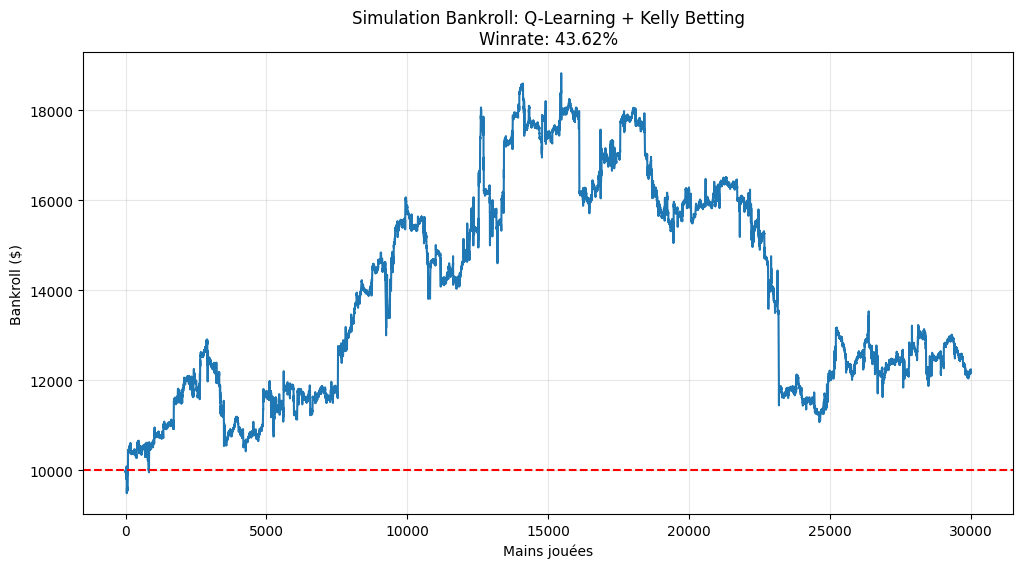

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history)
plt.title(f"Simulation Bankroll: Q-Learning + Kelly Betting\nWinrate: {w/(w+l+d):.2%}")
plt.xlabel("Mains jouées")
plt.ylabel("Bankroll ($)")
plt.axhline(y=10000, color='r', linestyle='--', label="Départ")
plt.grid(True, alpha=0.3)
plt.show()

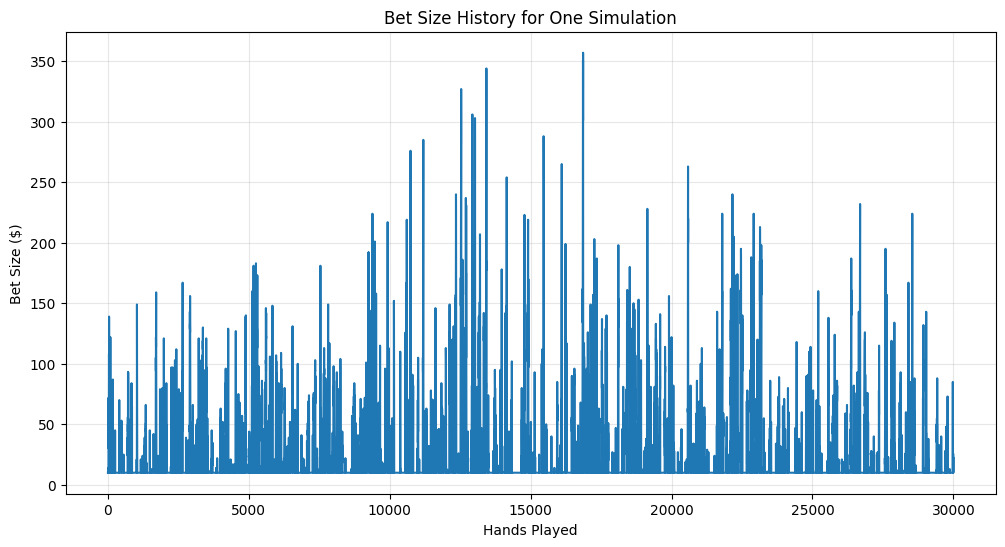

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(bets_history)
plt.title("Bet Size History for One Simulation")
plt.xlabel("Hands Played")
plt.ylabel("Bet Size ($)")
plt.grid(True, alpha=0.3)
plt.show()

## Visualization

In [ ]:
ACTIONS_STR = ['STAND', 'HIT', 'DOUBLE']
DEALER_CARDS = list(range(2, 11)) + [11] # 2-10, A (11)

def get_optimal_policy_matrix(q_agent, usable_ace, count_bucket):
    policy_matrix = []
    # Player sums range from 4 to 21 (inclusive)
    for player_sum in range(4, 22):
        row = []
        for dealer_card in DEALER_CARDS:
            state = (player_sum, dealer_card, usable_ace, count_bucket)
            # Q_agent.Q is a defaultdict, so unseen states will return np.zeros(len(ACTIONS))
            q_values = q_agent.Q[state]
            optimal_action_index = np.argmax(q_values)
            row.append(optimal_action_index)
        policy_matrix.append(row)
    return policy_matrix

In [ ]:
hard_policy_matrix_cold = get_optimal_policy_matrix(agent, usable_ace=False, count_bucket=-1)
hard_policy_matrix_neutral = get_optimal_policy_matrix(agent, usable_ace=False, count_bucket=0)
hard_policy_matrix_hot = get_optimal_policy_matrix(agent, usable_ace=False, count_bucket=1)

soft_policy_matrix_cold = get_optimal_policy_matrix(agent, usable_ace=True, count_bucket=-1)
soft_policy_matrix_neutral = get_optimal_policy_matrix(agent, usable_ace=True, count_bucket=0)
soft_policy_matrix_hot = get_optimal_policy_matrix(agent, usable_ace=True, count_bucket=1)

print("Generated policy matrices for all count buckets.")

Generated policy matrices for all count buckets.


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Player sum labels for Y-axis (from 4 to 21)
PLAYER_SUM_LABELS = list(range(4, 22))

# Map numerical actions to string labels for heatmap annotations
def get_action_label(action_index):
    return ACTIONS_STR[action_index]

# Create subplots for Hard Totals across different count buckets
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Hard Totals: Cold Count', 'Hard Totals: Neutral Count', 'Hard Totals: Hot Count'))

# --- Cold Totals Heatmap ---
hard_cold_text = [[get_action_label(action) for action in row] for row in hard_policy_matrix_cold]
fig.add_trace(
    go.Heatmap(
        z=hard_policy_matrix_cold,
        x=DEALER_CARDS,
        y=PLAYER_SUM_LABELS,
        text=hard_cold_text,
        texttemplate="%{text}",
        textfont={"size":10},
        colorscale='Viridis',
        colorbar_title='Action Index'
    ),
    row=1, col=1
)

# --- Neutral Totals Heatmap ---
hard_neutral_text = [[get_action_label(action) for action in row] for row in hard_policy_matrix_neutral]
fig.add_trace(
    go.Heatmap(
        z=hard_policy_matrix_neutral,
        x=DEALER_CARDS,
        y=PLAYER_SUM_LABELS,
        text=hard_neutral_text,
        texttemplate="%{text}",
        textfont={"size":10},
        colorscale='Viridis',
        colorbar_title='Action Index'
    ),
    row=1, col=2
)

# --- Hot Totals Heatmap ---
hard_hot_text = [[get_action_label(action) for action in row] for row in hard_policy_matrix_hot]
fig.add_trace(
    go.Heatmap(
        z=hard_policy_matrix_hot,
        x=DEALER_CARDS,
        y=PLAYER_SUM_LABELS,
        text=hard_hot_text,
        texttemplate="%{text}",
        textfont={"size":10},
        colorscale='Viridis',
        colorbar_title='Action Index'
    ),
    row=1, col=3
)

# Update layout
fig.update_layout(
    title_text='Q-Learning Optimal Blackjack Strategy for Hard Totals by Count Bucket',
    height=700, width=1500,
    xaxis=dict(title='Dealer Up-Card'),
    yaxis=dict(title='Player Hand Total', autorange='reversed', tickmode='array', tickvals=PLAYER_SUM_LABELS),
    xaxis2=dict(title='Dealer Up-Card'),
    yaxis2=dict(title='Player Hand Total', autorange='reversed', tickmode='array', tickvals=PLAYER_SUM_LABELS),
    xaxis3=dict(title='Dealer Up-Card'),
    yaxis3=dict(title='Player Hand Total', autorange='reversed', tickmode='array', tickvals=PLAYER_SUM_LABELS)
)

fig.show()


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Player sum labels for Y-axis (from 4 to 21)
PLAYER_SUM_LABELS = list(range(4, 22))

# Map numerical actions to string labels for heatmap annotations
def get_action_label(action_index):
    return ACTIONS_STR[action_index]

# Create subplots for Soft Totals across different count buckets
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Soft Totals: Cold Count', 'Soft Totals: Neutral Count', 'Soft Totals: Hot Count'))

# --- Cold Totals Heatmap ---
soft_cold_text = [[get_action_label(action) for action in row] for row in soft_policy_matrix_cold]
fig.add_trace(
    go.Heatmap(
        z=soft_policy_matrix_cold,
        x=DEALER_CARDS,
        y=PLAYER_SUM_LABELS,
        text=soft_cold_text,
        texttemplate="%{text}",
        textfont={"size":10},
        colorscale='Viridis',
        colorbar_title='Action Index'
    ),
    row=1, col=1
)

# --- Neutral Totals Heatmap ---
soft_neutral_text = [[get_action_label(action) for action in row] for row in soft_policy_matrix_neutral]
fig.add_trace(
    go.Heatmap(
        z=soft_policy_matrix_neutral,
        x=DEALER_CARDS,
        y=PLAYER_SUM_LABELS,
        text=soft_neutral_text,
        texttemplate="%{text}",
        textfont={"size":10},
        colorscale='Viridis',
        colorbar_title='Action Index'
    ),
    row=1, col=2
)

# --- Hot Totals Heatmap ---
soft_hot_text = [[get_action_label(action) for action in row] for row in soft_policy_matrix_hot]
fig.add_trace(
    go.Heatmap(
        z=soft_policy_matrix_hot,
        x=DEALER_CARDS,
        y=PLAYER_SUM_LABELS,
        text=soft_hot_text,
        texttemplate="%{text}",
        textfont={"size":10},
        colorscale='Viridis',
        colorbar_title='Action Index'
    ),
    row=1, col=3
)

# Update layout
fig.update_layout(
    title_text='Q-Learning Optimal Blackjack Strategy for Soft Totals by Count Bucket',
    height=700, width=1500,
    xaxis=dict(title='Dealer Up-Card'),
    yaxis=dict(title='Player Hand Total', autorange='reversed', tickmode='array', tickvals=PLAYER_SUM_LABELS),
    xaxis2=dict(title='Dealer Up-Card'),
    yaxis2=dict(title='Player Hand Total', autorange='reversed', tickmode='array', tickvals=PLAYER_SUM_LABELS),
    xaxis3=dict(title='Dealer Up-Card'),
    yaxis3=dict(title='Player Hand Total', autorange='reversed', tickmode='array', tickvals=PLAYER_SUM_LABELS)
)

fig.show()


# Winrate

In [ ]:
num_monte_carlo_runs = 100
n_hands_per_run = 30000
starting_bankroll = 10000

all_final_bankrolls = []
all_win_rates = []
all_histories = []

print("Monte Carlo simulation parameters and data structures initialized.")

Monte Carlo simulation parameters and data structures initialized.


In [ ]:
for i in range(num_monte_carlo_runs):
    print(f"Running Monte Carlo simulation {i+1}/{num_monte_carlo_runs}...")
    env = BlackjackEnv()

    history, bets_history, wins, losses, draws = run_test_with_betting(agent, env, n_hands=n_hands_per_run, bankroll=starting_bankroll)

    all_histories.append(history)

    total_games = wins + losses + draws
    win_rate = wins / total_games if total_games > 0 else 0
    all_win_rates.append(win_rate)

    all_final_bankrolls.append(history[-1])

print("Monte Carlo simulations completed. Results stored.")

Running Monte Carlo simulation 1/100...
Running Monte Carlo simulation 2/100...
Running Monte Carlo simulation 3/100...
Running Monte Carlo simulation 4/100...
Running Monte Carlo simulation 5/100...
Running Monte Carlo simulation 6/100...
Running Monte Carlo simulation 7/100...
Running Monte Carlo simulation 8/100...
Running Monte Carlo simulation 9/100...
Running Monte Carlo simulation 10/100...
Running Monte Carlo simulation 11/100...
Running Monte Carlo simulation 12/100...
Running Monte Carlo simulation 13/100...
Running Monte Carlo simulation 14/100...
Running Monte Carlo simulation 15/100...
Running Monte Carlo simulation 16/100...
Running Monte Carlo simulation 17/100...
Running Monte Carlo simulation 18/100...
Running Monte Carlo simulation 19/100...
Running Monte Carlo simulation 20/100...
Running Monte Carlo simulation 21/100...
Running Monte Carlo simulation 22/100...
Running Monte Carlo simulation 23/100...
Running Monte Carlo simulation 24/100...
Running Monte Carlo simul

In [ ]:
import numpy as np

average_final_bankroll = np.mean(all_final_bankrolls)
average_win_rate = np.mean(all_win_rates)

print(f"\n--- Monte Carlo Simulation Summary ---")
print(f"Average Final Bankroll: ${average_final_bankroll:.2f}")
print(f"Average Win Rate: {average_win_rate:.2%}")
print(f"Standard Deviation of Final Bankroll: ${np.std(all_final_bankrolls):.2f}")



--- Monte Carlo Simulation Summary ---
Average Final Bankroll: $11596.87
Average Win Rate: 43.76%
Standard Deviation of Final Bankroll: $3145.78


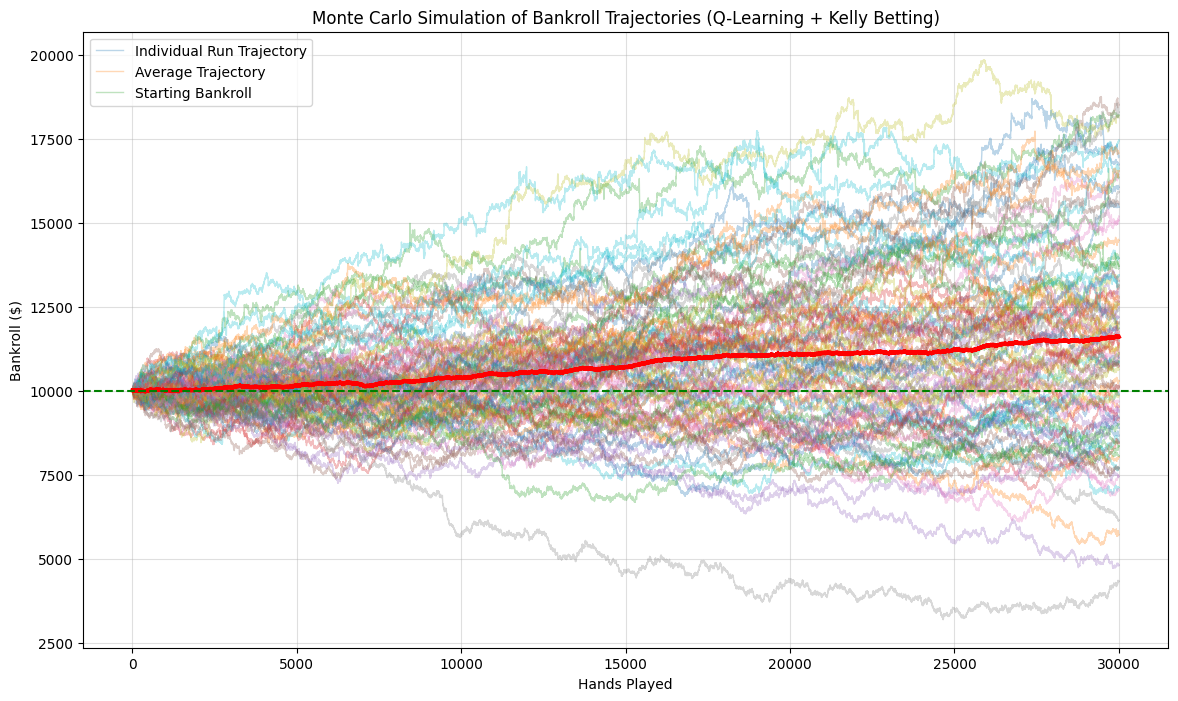

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

for i, history in enumerate(all_histories):
    plt.plot(history, alpha=0.3, linewidth=1, label=f'Run {i+1}' if i == 0 else "")

# Plot the average trajectory
# First, align all histories to the same length (n_hands_per_run)
# If histories are already of uniform length, this step is for robustness
max_len = max(len(h) for h in all_histories)
# Pad shorter histories or truncate longer ones if necessary to ensure uniform length for mean calculation
# Assuming all histories are of n_hands_per_run length from run_test_with_betting function

# Convert list of lists to numpy array for easy mean calculation
# Ensure all inner lists are of the same length, if not, handle padding/truncation
padded_histories = np.array([np.pad(h, (0, max_len - len(h)), 'edge') if len(h) < max_len else h[:max_len] for h in all_histories])

mean_history = np.mean(padded_histories, axis=0)
plt.plot(mean_history, color='red', linewidth=3, label='Average Trajectory')

plt.title('Monte Carlo Simulation of Bankroll Trajectories (Q-Learning + Kelly Betting)')
plt.xlabel('Hands Played')
plt.ylabel('Bankroll ($)')
plt.axhline(y=starting_bankroll, color='green', linestyle='--', label='Starting Bankroll')
plt.grid(True, alpha=0.4)
plt.legend(['Individual Run Trajectory', 'Average Trajectory', 'Starting Bankroll'])
plt.show()


In [ ]:
(30_000 // 60) // 24
11596 /(30_000 / 60)

23.192

In [ ]:
history, bets_history, w, l, d = run_test_with_betting(agent, env, n_hands=30000)

plt.figure(figsize=(12, 6))
plt.plot(bets_history)
plt.title("Bet Size History for One Simulation")
plt.xlabel("Hands Played")
plt.ylabel("Bet Size ($)")
plt.grid(True, alpha=0.3)
plt.show()